# 🧩 Notebook 02: Hypothesis Testing with SciPy

In [1]:
# Setup and Imports
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# ✅ Setup path to use utils
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import utilities
from utils.stats_tests_utils import (
    run_one_sample_ttest,
    run_two_sample_ttest,
    run_paired_ttest,
    run_normality_tests,
    run_variance_tests,
    run_mannwhitney_u_test, 
    format_mannwhitney_result,
    format_test_result,
    cohens_d_independent,
    hedges_g_independent,
    cliffs_delta,
    format_effect_sizes,
    run_spearman_correlation,
    run_kendall_tau,
    run_wilcoxon_signedrank,
    rank_biserial_effect_size
)


from utils.viz_utils import (
    plot_histograms,
    plot_violin_swarm,
    plot_ranked_barplots,
    plot_ranked_boxplot,
    save_and_show_plot
)

# Paths
DATA_PATH = Path("../synthetic_data/exports")
EXPORT_PLOTS = Path("../exports/plots/02_hypothesis_tests")
EXPORT_TABLES = Path("../exports/tables/02_hypothesis_tests")

EXPORT_PLOTS.mkdir(parents=True, exist_ok=True)
EXPORT_TABLES.mkdir(parents=True, exist_ok=True)

## 🔹 Step 1: Load the Dataset

In [ ]:
# Loading the Dataset
df = pd.read_csv(DATA_PATH / "normal_skewed.csv")
df.head().to_csv(EXPORT_TABLES / "dataset_preview.csv", index=False)
df.head()

## 🔹 Step 2: One-Sample T-Test on "normal" against μ = 50

In [3]:
# One-Sample T-Test on "normal" against μ = 50
result = run_one_sample_ttest(df['normal'], popmean=50)
format_test_result(result, "One-Sample T-Test")
pd.DataFrame([result]).to_csv(EXPORT_TABLES / "one_sample_ttest.csv", index=False)

📌 One-Sample T-Test Results
  t_stat: 0.6243
  p_value: 0.5326


## 🔹 Step 3: Two-Sample T-Test (normal vs skewed)

In [4]:
# Two-Sample T-Test (normal vs skewed)
# Two-Sample Equal
result_equal = run_two_sample_ttest(df['normal'], df['skewed'], equal_var=True)
format_test_result(result_equal, "Two-Sample T-Test (equal variance)")
pd.DataFrame([result_equal]).to_csv(EXPORT_TABLES / "two_sample_equal_var.csv", index=False)

📌 Two-Sample T-Test (equal variance) Results
  t_stat: -50.8771
  p_value: 0.0000


In [5]:
# Two-Sample Unequal
result_unequal = run_two_sample_ttest(df['normal'], df['skewed'], equal_var=False)
format_test_result(result_unequal, "Two-Sample T-Test (unequal variance)")
pd.DataFrame([result_unequal]).to_csv(EXPORT_TABLES / "two_sample_unequal_var.csv", index=False)

📌 Two-Sample T-Test (unequal variance) Results
  t_stat: -50.8771
  p_value: 0.0000


## 🔹 Step 4: Paired T-Test Simulation

In [6]:
# Create synthetic before-after data
before = df['normal']
after = df['normal'] + np.random.normal(loc=1.0, scale=2.0, size=len(before))

before_after_df = pd.DataFrame({"before": before, "after": after})
before_after_df.to_csv(EXPORT_TABLES / "paired_data_simulated.csv", index=False)

In [7]:
# Paired T-Test Simulation
result_paired = run_paired_ttest(before, after)
format_test_result(result_paired, "Paired T-Test")
pd.DataFrame([result_paired]).to_csv(EXPORT_TABLES / "paired_ttest.csv", index=False)

📌 Paired T-Test Results
  t_stat: -14.8884
  p_value: 0.0000


## 🔹 Step 5: Normality Assumptions

In [8]:
# Normality Assumptions
print("Normality Tests on 'normal':")
norm_results = run_normality_tests(df['normal'])
for k, v in norm_results.items():
    print(f"{k}: {v}")

# Normalize test results
normalized_results = {
    "shapiro": {
        "statistic": norm_results["shapiro"].statistic,
        "p-value": norm_results["shapiro"].pvalue
    },
    "dagostino": {
        "statistic": norm_results["dagostino"].statistic,
        "p-value": norm_results["dagostino"].pvalue
    },
    "anderson": {
        "statistic": norm_results["anderson"].statistic,
        "critical_values": norm_results["anderson"].critical_values.tolist(),
        "significance_levels": norm_results["anderson"].significance_level.tolist(),
        "fit_success": norm_results["anderson"].fit_result.success,
        "fit_message": norm_results["anderson"].fit_result.message
    }
}

# Convert and export
pd.DataFrame.from_dict(normalized_results, orient="index").to_csv(
    EXPORT_TABLES / "normality_tests.csv"
)

Normality Tests on 'normal':
shapiro: ShapiroResult(statistic=np.float64(0.9986092190571162), pvalue=np.float64(0.6272578290246378))
dagostino: NormaltestResult(statistic=np.float64(2.575517854321579), pvalue=np.float64(0.27588837674285993))
anderson: AndersonResult(statistic=np.float64(0.3474697767348971), critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(50.193320558223256), scale=np.float64(9.792159381796758))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


## 🔹 Step 6: Variance Tests (normal vs skewed)

In [9]:
# Variance Tests (normal vs skewed)
var_results = run_variance_tests(df['normal'], df['skewed'])
for k, v in var_results.items():
    print(f"{k}: {v}")

pd.DataFrame(var_results).T.to_csv(EXPORT_TABLES / "variance_tests.csv")

levene: LeveneResult(statistic=np.float64(4.271360843824999), pvalue=np.float64(0.03888844061696694))
bartlett: BartlettResult(statistic=np.float64(3.8275291502051303), pvalue=np.float64(0.05041720413474201))
fligner: FlignerResult(statistic=np.float64(5.238838703992071), pvalue=np.float64(0.022088013580533347))


## 🔹 Step 7: 📏 Effect Size Calculations

In [10]:
# Split normal data
group1 = df["normal"][:500]
group2 = df["normal"][500:]

effect_d = cohens_d_independent(group1, group2)
effect_g = hedges_g_independent(group1, group2)
effect_delta = cliffs_delta(group1, group2)

format_effect_sizes(effect_d, effect_g, effect_delta)

effect_df = pd.DataFrame([{
    "Cohen’s d": round(effect_d, 3),
    "Hedges’ g": round(effect_g, 3),
    "Cliff’s Delta": round(effect_delta, 3)
}])
effect_df.to_csv(EXPORT_TABLES / "effect_sizes.csv", index=False)

📐 Effect Size Metrics:
  • Cohen’s d     : -0.026
  • Hedges’ g     : -0.025
  • Cliff’s Delta : -0.018


## 🔹 Step 8: Visualize for Intuition

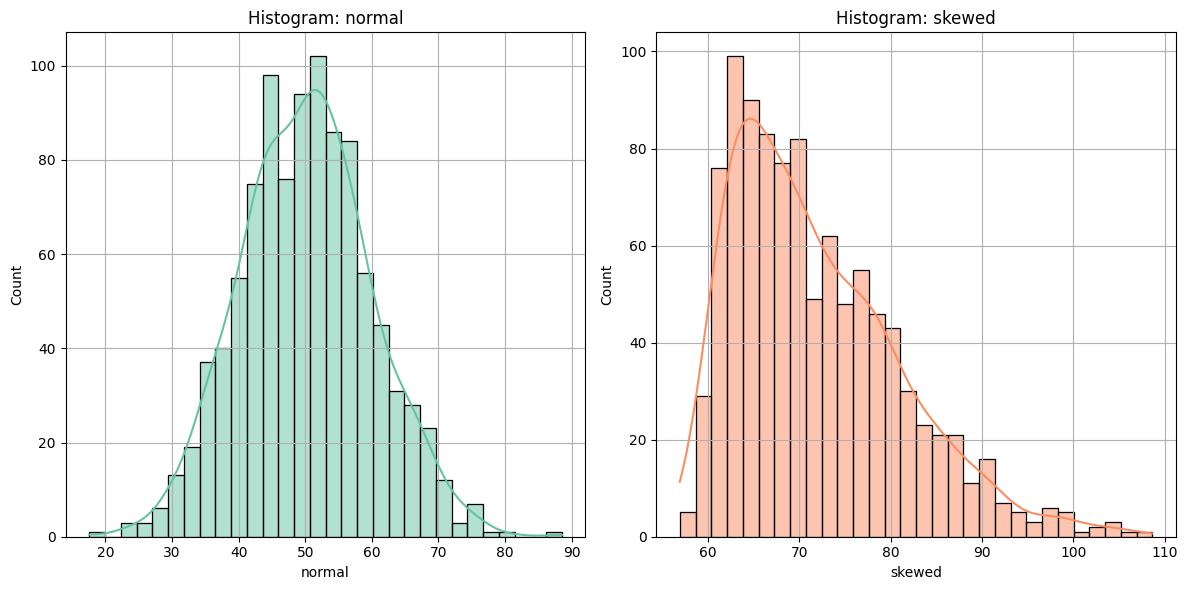

In [11]:
# Visualize for Intuition
fig = plot_histograms(df, ['normal', 'skewed'])
save_and_show_plot(fig, EXPORT_PLOTS / "histograms_normal_skewed.png")

## 🔹 Step 9: 🎻 Violin + Swarm Plot (optional but on-theme)

/Users/satvikpraveen/Desktop/Libraries/SciPyMasterPro/utils/viz_utils.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=x_col, y=y_col, inner=None, palette=palette, ax=ax)


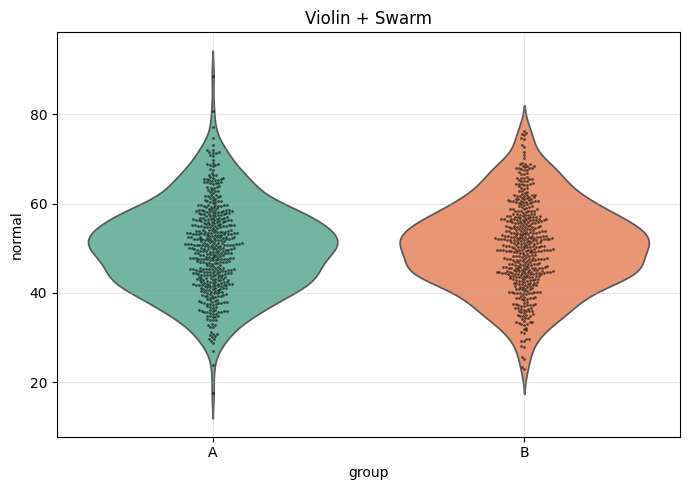

In [12]:
# Simulate group labels for violin plot
df_vis = df[["normal"]].copy()
df_vis["group"] = ["A"] * 500 + ["B"] * 500

fig_vs = plot_violin_swarm(df_vis, x_col="group", y_col="normal")
save_and_show_plot(fig_vs, EXPORT_PLOTS / "violin_swarm_groups.png")

## 🔹 Step 10: 🧪 Non-parametric Test (e.g., Mann-Whitney U Test)

In [13]:
# 📌 Mann–Whitney U Test
result_u = run_mannwhitney_u_test(df["skewed"][:500], df["skewed"][500:])
format_mannwhitney_result(result_u)
pd.DataFrame([result_u]).to_csv(EXPORT_TABLES / "mann_whitney_u_test.csv", index=False)

Mann–Whitney U Test (two-sided): stat = 127812.000, p = 0.5381


## 🔹 Step 11: Rank-Based Nonparametric Tests

In [14]:
## 🔹 Step 11: Rank-Based Nonparametric Tests

# Simulate ordinal-like paired data
np.random.seed(42)
x_ranked = np.random.randint(1, 6, size=100)         # e.g., Likert scale [1–5]
y_ranked = x_ranked + np.random.choice([-1, 0, 1], size=100)
y_ranked = np.clip(y_ranked, 1, 5)                   # Keep within 1–5 range


# 🧪 Spearman correlation
spearman_result = run_spearman_correlation(x_ranked, y_ranked)

# 🧪 Kendall's Tau
kendall_result = run_kendall_tau(x_ranked, y_ranked)

# 🧪 Wilcoxon signed-rank test (for paired ordinal data)
wilcoxon_result = run_wilcoxon_signedrank(x_ranked, y_ranked)

# 📏 Rank-Biserial Effect Size
rb_effect_size = rank_biserial_effect_size(x_ranked, y_ranked)

print("📊 Rank-Based Nonparametric Test Results:")
print(f"  • Spearman ρ      : {spearman_result['spearman_r']:.3f} (p = {spearman_result['p_value']:.4f})")
print(f"  • Kendall’s τ     : {kendall_result['kendall_tau']:.3f} (p = {kendall_result['p_value']:.4f})")
print(f"  • Wilcoxon stat   : {wilcoxon_result['statistic']:.3f} (p = {wilcoxon_result['p_value']:.4f})")
print(f"  • Rank-Biserial Δ : {rb_effect_size:.3f}")

rank_results_df = pd.DataFrame([{
    "Spearman_rho": round(spearman_result['spearman_r'], 3),
    "Spearman_p": round(spearman_result['p_value'], 4),
    "Kendall_tau": round(kendall_result['kendall_tau'], 3),
    "Kendall_p": round(kendall_result['p_value'], 4),
    "Wilcoxon_stat": round(wilcoxon_result['statistic'], 3),
    "Wilcoxon_p": round(wilcoxon_result['p_value'], 4),
    "Rank-Biserial": round(rb_effect_size, 3)
}])

rank_results_df.to_csv(EXPORT_TABLES / "rank_based_tests.csv", index=False)


📊 Rank-Based Nonparametric Test Results:
  • Spearman ρ      : 0.845 (p = 0.0000)
  • Kendall’s τ     : 0.738 (p = 0.0000)
  • Wilcoxon stat   : 810.000 (p = 0.5151)
  • Rank-Biserial Δ : -0.018


## 🔹 Step 12: Visualize Ranked Distributions

/Users/satvikpraveen/Desktop/Libraries/SciPyMasterPro/utils/viz_utils.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="score", y="count", data=df_x, ax=ax[0], palette="Blues_d")
/Users/satvikpraveen/Desktop/Libraries/SciPyMasterPro/utils/viz_utils.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="score", y="count", data=df_y, ax=ax[1], palette="Greens_d")


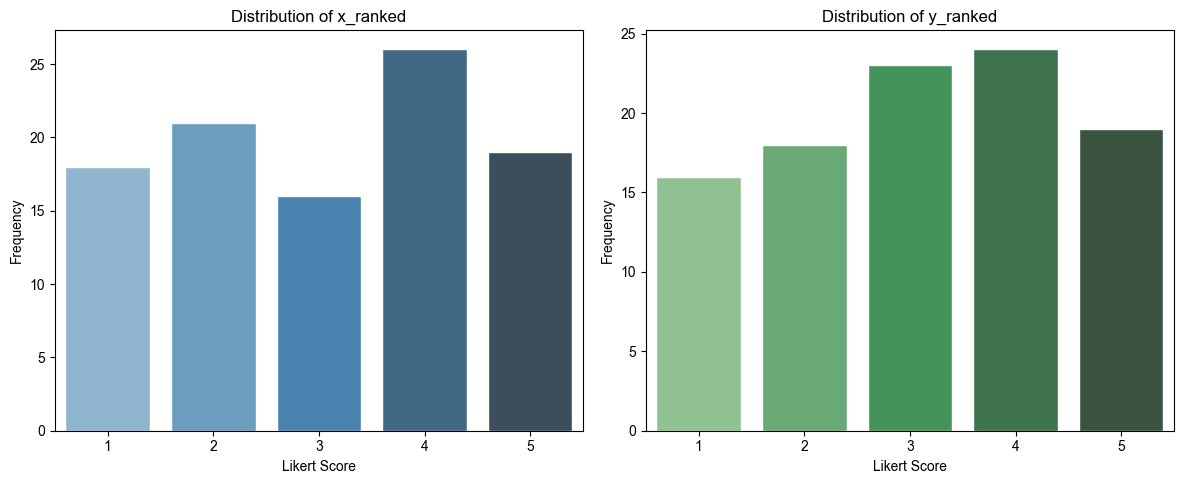

In [15]:
# Visualize
fig = plot_ranked_barplots(x_ranked, y_ranked)
save_and_show_plot(fig, EXPORT_PLOTS / "ranked_barplots.png")

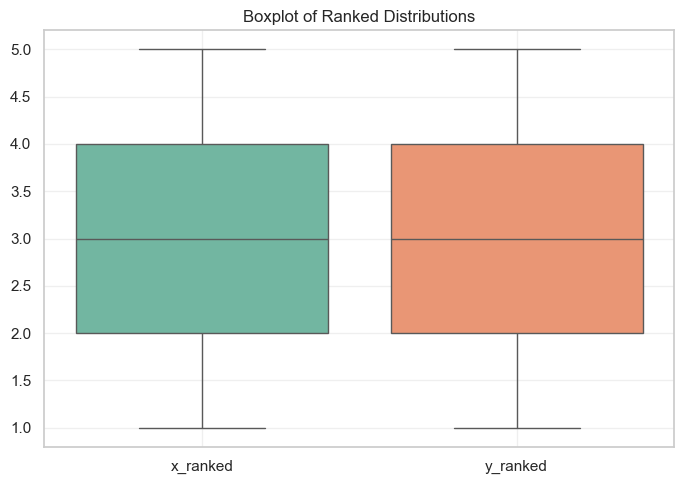

In [16]:
# Visualize
fig2 = plot_ranked_boxplot(x_ranked, y_ranked)
save_and_show_plot(fig2, EXPORT_PLOTS / "ranked_boxplot.png")

## 🧠 Key Takeaways

- SciPy offers flexible one-sample, two-sample, and paired t-tests
- Assumptions (normality, equal variance) must be verified using tools like Shapiro or Levene tests
- Always test equal and unequal variance versions of two-sample t-tests
- Simulated before-after effects (paired t-tests) can help benchmark sensitivity
- Visual inspection aids hypothesis test intuition (e.g., ECDF + histogram)

## ✅ Summary
In this notebook, we:

- Performed one-sample, two-sample (equal/unequal var), and paired t-tests
- Verified assumptions using Shapiro, D’Agostino, Levene, and Bartlett tests
- Calculated effect sizes (Cohen’s d, Hedges’ g, Cliff’s delta)
- Visualized test distributions via histograms and violin plots
- Included Mann–Whitney U for robustness (non-parametric)
- Exported all plots to exports/plots/02_hypothesis_tests/
